## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [67]:
#Importing the necessary packages/libraries needed to conduct the analysis.
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the seed to ensure quiz answers align with Udacity.
random.seed(42)

In [68]:
#Read in the ab_data.csv data and storing it as df.
df = pd.read_csv('/Users/holly/Desktop/PyJupyterNB/UDACITY Data Analyst/Project3/ab_data.csv')

In [69]:
#Reviewing the top few rows of data using head.
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [70]:
#Using shape to find the number of rows.
df.shape[0]

294478

In [71]:
#Using nunique to find the unique number of users in the dataset.
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [72]:
#Find the proportion of users who converted.
df['converted'].mean()

0.11965919355605512

In [73]:
#Find the number of times the new_page and treatment do not match. These are conflicting records.
df_new = df.query('landing_page == "new_page"')
df_new_control = df_new.query('group == "control"')
df_new_control.group.count()

1928

In [74]:
#Determine if any of the rows have mssing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [75]:
#Create new dataframes where the group aligns with the landing page -- treatment = new_page and control = old_page. Merge the data into new df2.
df_new = df.query('group == "treatment" and landing_page == "new_page"')
df_old = df.query('group == "control" and landing_page == "old_page"')
df2 = df_new.append(df_old)
df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [76]:
#Check that all of the correct rows were removed - this should be 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [77]:
#Find the unique number of users in df2.
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [78]:
#Find the dupliate user_id.
duplicate = df2[df2.duplicated('user_id')]
duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [79]:
#Source: https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
#Determine the row information for the repeat user_id.
pd.concat(g for _, g in df2.groupby("user_id") if len(g) > 1)

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [80]:
#Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
#Remove one of the duplicate records, but keep the df as df2.
df2 = df2.drop_duplicates(subset=['user_id'], inplace=False)

In [81]:
#Confirm that one of the duplicates was dropped by finding the number of rows. 
df2.shape[0]

290584

In [82]:
# Find the probability of an individual converting regardless of the page they receive.
convert = df2.query('converted == 1').user_id.nunique() / df2.shape[0]
convert

0.11959708724499628

In [83]:
#Find the probability than individual coverted if they were in the control group.
#Filter the records for indiviudals in the control group.
control = df2.query('group == "control"').user_id.nunique()

In [84]:
#Determine number of individuals who were in the control group and converted.
df2.query('group == "control" and converted == 1').user_id.nunique()

17489

In [85]:
#Determine the probability that an individual coverted if they were in the control group.
control_convert = df2.query('group == "control" and converted == 1').user_id.nunique() / control
control_convert

0.1203863045004612

In [86]:
#Filter the records for indiviudals in the treatment group.
treatment = df2.query('group == "treatment"').user_id.nunique()

In [87]:
##Determine the probability that an individual coverted if they were in the treatment group.
treatment_convert = df2.query('group == "treatment" and converted == 1').user_id.nunique() / df2.query('group == "treatment"').user_id.nunique()
treatment_convert

0.11880806551510564

In [88]:
#Find the probability that an individual received the new page.
new_page = df2.query('landing_page == "new_page"').user_id.nunique() / df2.shape[0]
new_page

0.5000619442226688

The probability of an individual converting regardless of the page they receive is 11.96%.
The probability that an individual from the control group converted is 12.04%.
The probability that an individual from the treatment group converted is 11.88%.
Since the treatment group and control group convert at about the same rate, with the control group converting minimally higher, and since about half of all users are in the treatment group, there does not appear to be sufficient evidence to suggest that the new page leads to more conversions. 

<a id='ab_test'></a>
### Part II - A/B Test


Null hypothesis, H0: p_new - p_old <= 0  
Alternative hypothesis, H1: p_new - p_old > 0 

In [89]:
#Find the conversion rate for p_new under the null.
p_new = (df2.query('converted == 1')['user_id'].nunique())/(df2['user_id'].nunique())
p_new

0.11959708724499628

In [90]:
#Find the conversion rate for p_old under the null.
p_old = (df2.query('converted == 1')['user_id'].nunique())/(df2['user_id'].nunique())
p_old

0.11959708724499628

In [91]:
#Find the number of individuals in the treatment group, n_new.
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
n_new

145310

In [92]:
#Find the number of individuals in the control group, n_old.
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique() 
n_old

145274

In [93]:
#Simulate n_new transactions with a conversion rate of p_new under the null. 
#Store these n_new 1's and 0's in new_page_converted.
#Source: https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html
#Source: https://www.sharpsightlabs.com/blog/numpy-random-choice/
#Source: https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array

new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [94]:
#Simulate n_old transactions with a conversion rate of p_old under the null. 
#Store these n_old 1's and 0's in old_page_converted.
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [95]:
#Find the average for new_page_converted.
new_page_converted.mean()

0.8814603261991604

In [96]:
#Find the average for old_page_converted.
old_page_converted.mean()

0.8803295840962595

In [97]:
#Find p_new - p_old for the simulated average values for new_page_converted - old_page_converted.
new_page_converted.mean() - old_page_converted.mean()

0.0011307421029008724

In [98]:
#Create 10,000 p_new - p_old values using the same simulation process used above. 
p_diffs = []
size = df.shape[0]
for _ in range(10000):
    samp = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
    old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [99]:
#Store all 10,000 values in a NumPy array called p_diffs.
p_diffs = np.array(p_diffs)

(array([  42.,  225.,  847., 1826., 2757., 2437., 1293.,  455.,  101.,
          17.]),
 array([-0.00404493, -0.00319422, -0.00234351, -0.0014928 , -0.0006421 ,
         0.00020861,  0.00105932,  0.00191003,  0.00276073,  0.00361144,
         0.00446215]),
 <BarContainer object of 10 artists>)

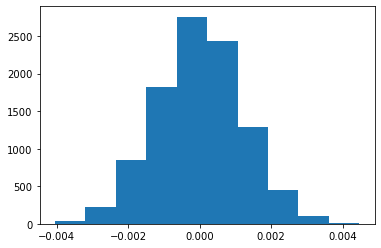

In [100]:
#Plot a histogram of the p_diffs. 
#Use the matching problem in the classroom to assure you fully understand what was computed here.
plt.hist(p_diffs)

In [101]:
#Find number of converted users by landing_page.
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()

In [102]:
#Compute actual converted rate for n_new and n_old.
actual_convert_new = (convert_new)/ (n_new) 
actual_convert_old = (convert_old)/ (n_old)

In [103]:
#Find the difference actual_cvt_new and actual_cvt_old.
obs_diff = actual_convert_new - actual_convert_old
obs_diff

-0.0015782389853555567

In [104]:
#Proportion of p_diffs that are greater than the actual difference observed in ab_data.csv?
#Source: https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.normal.html
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

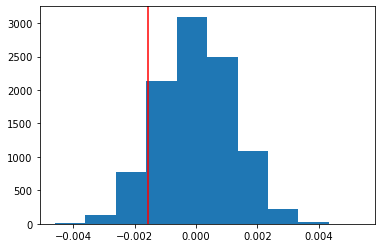

In [105]:
#Plot null_vals.
#Display where our sample mean falls on the null distribution using axvline.
plt.hist(null_vals);
plt.axvline(x=obs_diff,color ='red')

In [41]:
#Compare null_vals to obs_diff.
(null_vals > obs_diff).mean()

0.9061

Assuming a type I error rate of 5%, we fail to reject the null hyothesis since the p_value (0.1196) is greater than alpha (0.05). The p-value is the probability of observing our statistic or a more extreme statistic from the null hypothesis. When the p-value is large, we have evidence that our statistic likely came from the null hypothesis. Therefore, we do not have evidence to reject the null. 

Based on our analysis, the old page, p_old, has a slightly higher convertion rate than the new page, p_new.

In [42]:
#Calculate the number of conversions for each page, as well as the number of individuals who received each page. 
#Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()

n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

In [43]:
#Use stats.proportions_ztest to compute your test statistic and p-value. 
#Source: https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [44]:
#Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
#Compute the z score of each value in the sample, relative to the sample mean and standard deviation.
from scipy.stats import norm

In [45]:
#Source: https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa
#Source: https://dfrieds.com/math/z-scores.html
#Source: https://educationalresearchtechniques.com/2018/09/24/z-scores-and-inferential-stats-in-python/
#Calculate the percent of converted users that have a z-score of -1.31 or higher using cumulative distribution function.
norm.cdf(z_score)

0.09494168724097551

In [46]:
#Inverse of the cdf.
norm.ppf(1-(0.05/2))

1.959963984540054

Since the z-score is less than the critical value, we fail to reject the null hypothesis.  There is not enough evidence to suggest that the new page, n_new, has a greater conversion rate than the old page, p_old.
This aligns with the results we received above when evaluating the p_value against alpha.

<a id='regression'></a>
### Part III - A regression approach


The most appropriate regression to use in this case will be logistic regression since there are only two possible outcomes; conversion or no conversion. in logistic regression, the responses varibale can be categorical or continuous. Independence between variables is aaumed.

In [47]:
#Importing necessary libraries/packages. 
# The goal is to use statsmodels to fit the regression model you specified in part a. 
# to see if there is a significant difference in conversion based on which page a customer receives. 
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [48]:
#Create a column for intercept in df2.
df2['intercept'] = 1

In [49]:
#Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
# Create a dummy variable column for which page each user received; new_page or old_page.
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [50]:
#Create a dummy variable column for ab_page: 1 when an individual receives the treatment and 0 if control.
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1


In [51]:
#Use statsmodels to instantiate regression model on converted variable and ab_page, where control is the baseline.
lo = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

In [52]:
#Fit the model on converted variable and ab_page to predict whether or not an individual converts.
results = lo.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [53]:
#https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.summary2.html?highlight=summary2#statsmodels.discrete.discrete_model.LogitResults.summary2
#Provide summary of model.
print(results.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2020-12-13 17:06 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



The p_value associated with ab_page is 0.1899. The null hypothesis suggests that there is no difference between the treatment and control group, whereas in Part II, we assume the old page is better unless the new page performs better given a type I error rate of 5%. Since the p_value is greater than alpha, we fail to reject the null hypothesis. In part III, the p_value is also greater than alpha, but by a larger margin. This is because we have a different explanatory variable for the result, but we still fail to reject the null hypothesis.

The alternative hypothesis associated with the regression model suggests there is a difference between the treatment and control group, whereas in part II, we would expect a greater conversion rate for the treatment group, which we do not find.

An advantage to adding other factors to our analysis is that we can provide a more robust analysis as we explore what may contribute to why a user converts, or not, as this may impact our analysis and recommendations for future changes. In this example, the only other data we have to consider is the timestamp. We could perform further exploration to see if the time of day or the day of the week affects the conversion rate.

A disadvantage to adding other factors to our analysis is that this makes our results more difficult to interpret and may require further analysis in certain situations, such as the need to add a higher order term. Further, we have to be careful not to suggest causation with our regression model.

In [55]:
#We want to test if the conversion rate changes for different pages based on which country a user lives in. 
#Read in the countries dataset.
c = pd.read_csv('/Users/holly/Desktop/PyJupyterNB/UDACITY Data Analyst/Sample Solutions/countries.csv')
c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [56]:
#Merge df2 with c to create df3.
df3 = df2.merge(c, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA


In [57]:
#Identify which countries exist in df3.
c['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [58]:
#Create dummy variables for the 3 varibales and drop CA.
#Drop CA to make the matrix full rank, linearly independent. 
#Source: https://www.cds.caltech.edu/~murray/amwiki/index.php/FAQ:_What_does_it_mean_for_a_non-square_matrix_to_be_full_rank%3F
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])

In [59]:
#Create an intercept for our model.
df3['intercept'] = 1

In [60]:
#Create Logit regression model for converted and country; CA and old_page will serve as the baseline.
logit = sm.Logit(df3['converted'], df3[['intercept','new_page','UK','US']])
results = logit.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6196
Date:               2020-12-13 17:08 BIC:              212822.9382
No. Observations:   290582           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.17627    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2490  0.0000  -2.0822  -1.9779
new_page      -0.0149    0.0114   -1.3055  0.1917

In [61]:
#Provide estimated coefficients which are easier to interpret.
#Source: https://numpy.org/doc/stable/reference/generated/numpy.exp.html
#Source: https://www.juanshishido.com/logisticcoefficients.html
1/np.exp(-0.0150),np.exp(0.0506),np.exp(0.0408)

(1.015113064615719, 1.0519020483004984, 1.0416437559600236)

We see that the log odds are above 1 for country and new_page, which tells us that they are positively associated with the response variable, converted.

In [62]:
#Create new columns to look at conversion rates by country to confirm significance.
df3['UK_new_page'] = df3['new_page']* df3['UK']
df3['US_new_page'] = df3['new_page']* df3['US']

In [63]:
#Create logistic regression to look at the interaction between page and country to see if there are significant 
# effects on conversion. 
df3['intercept'] = 1
logit = sm.Logit(df3['converted'], df3[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
results = logit.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.1559
Date:               2020-12-13 17:09 BIC:              212845.6337
No. Observations:   290582           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290576           LLR p-value:      0.19233    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
new_page      -0.0674    0.0520   -1.2967  0.1947

In [64]:
#Look at log results.
np.exp(results.params)

intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.048024
UK             1.011854
US             1.017682
dtype: float64

Here, we see that the log odds are above 1 for country and country new_page, which tells us that they are positively associated with conversion rate.

In conclusion, it does not appear that we have enough evidence to suggest that the new page will lead to higher conversions and therefore, we cannot recommend that the company implement the new page at this time.

In [66]:
from subprocess import call
call(['python', '-m', 'nbconvert', '12132020 Analyze_ab_test_results_notebook FINAL'])

1